## Final Project
##### Valeria Izeppi
##### 12/4/2023

### Goal: To analyze the relationships between dissolved oxygen and nutrients, chl-a, and temperature over the study period (2016-2022) in the Long Island Sound.

### Data: Accessed from Interstate Environmental Commission Long Island Sound Study, for the years 2016-2022, excluding 2018. Method of data collection in-situ measurements and laboratory analyses.

### Analysis Outline: 
##### Map the study area (cartopy)
##### Visualize changes in dissolved oxygen, chl-a, and nutrients with plots (timeseries and climatology)
##### Plot correlations between dissolved oxygen and other parameters (scatter plots)
##### Determine which sample stations have the lowest dissolved oxygen (groupby, aggregation, plots)
##### Perform linear regression between dissolved oxygen and other parameters (statsmodel)
##### Build a model to predict dissolved oxygen (statsmodel)

### Method : Python packages Pandas, Numpy, Matplotlib, Cartopy, Statsmodel, Patsy


In [332]:
# import packages

#for data processing and analysis
import pandas as pd
import numpy as np

#for making plots and graphs
import matplotlib.pyplot as plt
from matplotlib.axis import Axis

#for making maps
import cartopy as cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#for linear regression and building model
import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
#if statsmodel is not installed yet, may use mamba or conda (mamba very fast!)
#mamba install -c conda-forge statsmodels


### Read in and Format Data

In [333]:
# read in the raw data csvs
# Replace ND (no data) and nans in dataset with NaN
df_16 = pd.read_csv('/home/vgi3/rcaes/Final_Project/LIS 2016 DB.csv', parse_dates = ['DATE'], index_col=0, na_values=['ND','nan'])
df_17 = pd.read_csv('/home/vgi3/rcaes/Final_Project/LIS 2017 DB.csv', parse_dates = ['DATE'], index_col=0, na_values=['ND','nan'])
df_19 = pd.read_csv('/home/vgi3/rcaes/Final_Project/LIS 2019 DB draft.csv', parse_dates = ['DATE'], index_col=0, na_values=['ND','nan'])
dF_20 = pd.read_csv('/home/vgi3/rcaes/Final_Project/LIS 2020 DB.csv', parse_dates = ['DATE'], index_col=0, na_values=['ND','nan'])
df_21 = pd.read_csv('/home/vgi3/rcaes/Final_Project/LIS 2021 DB.csv', parse_dates = ['DATE'], index_col=0, na_values=['ND','nan'])
df_22 = pd.read_csv('/home/vgi3/rcaes/Final_Project/LISS RUNS 2022_DB.csv', parse_dates = ['DATE'], index_col=0, na_values=['ND','nan'])

In [334]:
#combine the dataframes to make ones dataframe
df = pd.concat([df_16, df_17, df_19, dF_20, df_21, df_22])

In [335]:
#explore dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7335 entries, 18916.0 to 26498.0
Data columns (total 77 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RECORD_ID                6614 non-null   object        
 1   DATE_STATION_LINK        6614 non-null   object        
 2   DATE                     6614 non-null   datetime64[ns]
 3   YEAR                     6614 non-null   float64       
 4   MONTH                    6614 non-null   object        
 5   TIME_24H                 6610 non-null   object        
 6   STATION_ID               6614 non-null   object        
 7   DEPTH_M                  6587 non-null   float64       
 8   CLASS                    6612 non-null   object        
 9   DISSOLVED_OXYGEN_MG_L    6574 non-null   float64       
 10  TEMPERATURE_C            6573 non-null   float64       
 11  SALINITY_PSU             6572 non-null   float64       
 12  CHLA_UG_L                1350 

## Data Cleanup

#### Remove excess columns

In [336]:
#drop columns not used in analysis and excessive columns (unnamed)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(['EDIT NOTES', 'FIELD_NOTES', 'SECCHI_DEPTH_M', 'SECCHI_DEPTH_F', 'LISS_STUDY_AREA', 'CLOUD_COVER', 'SAMPLING SURVEY RUN', 'TIDE_TIME_NR', 'TIDE_RANGE_FT_NR', 'BOD5_MG_L', 'TIDE_TYPE_NR', 'TIDE_TIME_KP', 'TIDE_RANGE_FT_KP', 'TIDE_RANGE_FT_KP', 'TIDE_TYPE_KP', 'TSS_MG_L'], axis=1)

#### Correct Dataypes

In [337]:
#examine dataframe columns and examine the datatypes. Consists of object, datetime64[ns], float64
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7335 entries, 18916.0 to 26498.0
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RECORD_ID                6614 non-null   object        
 1   DATE_STATION_LINK        6614 non-null   object        
 2   DATE                     6614 non-null   datetime64[ns]
 3   YEAR                     6614 non-null   float64       
 4   MONTH                    6614 non-null   object        
 5   TIME_24H                 6610 non-null   object        
 6   STATION_ID               6614 non-null   object        
 7   DEPTH_M                  6587 non-null   float64       
 8   CLASS                    6612 non-null   object        
 9   DISSOLVED_OXYGEN_MG_L    6574 non-null   float64       
 10  TEMPERATURE_C            6573 non-null   float64       
 11  SALINITY_PSU             6572 non-null   float64       
 12  CHLA_UG_L                1350 

In [339]:
### Convert Object Columns to Numeric so they can be used for analysis
### Use a loop for efficient analysis
column_list = ['PH','PREV_48_H_RAIN','AMMONIA-AMMONIUM_MG_L', 'NITRITE_NITRATE_MG_L', 'PARTICULATE_N_MG_L', 'ORTHOPHOSPHATE_MG_L', 'TOTAL_DISSOLVED_ N_MG_L', 'TOTAL_DISSOLVED_P_MG_L', 'PARTICULATE_C_MG_L','PARTICULATE_P_MG_L', 'DOC_MG_L', 'DISSOLVED_SILICA_MG_L', 'BIOGENIC_SILICA_MG_L', 'SALINITY_PSU']
for icolumn in column_list:
    df[icolumn] = pd.to_numeric(df[icolumn],  errors = 'coerce')
#the error=coerce converts errors to NaNs

In [340]:
#read in the location file which containts the station ID latitudes and longitudes
location = pd.read_csv('/home/vgi3/rcaes/Final_Project/ArcGIS Data 2022.xlsx .csv')

In [341]:
#open file
location

,STATION_ID,LAT_DD,LONG_DD
0,8-403,40.77791,-73.76083
1,8-405,40.78889,-73.75806
2,9-409,40.82423,-73.71767
3,9-412,40.82009,-73.71357
4,9-413,40.80436,-73.71353
5,A1,40.80110,-73.82747
6,A2M,40.79926,-73.79131
7,A3,40.84348,-73.75935
8,A4,40.87259,-73.73428
9,A5,40.89229,-73.68531


In [342]:
# To add the lat and long to the stations to the original data, first reindex both dataframes to STATION_ID
location = location.set_index('STATION_ID')
df = df.set_index('STATION_ID')

In [343]:
# add longitude and latitude from location dataframe to df dataframe as new columns, according to station id index
df['LAT_DD'] =location['LAT_DD']
df['LONG_DD'] = location['LONG_DD']

In [344]:
#check index is Station_ID
df

,RECORD_ID,DATE_STATION_LINK,DATE,YEAR,MONTH,TIME_24H,DEPTH_M,CLASS,DISSOLVED_OXYGEN_MG_L,TEMPERATURE_C,...,DISSOLVED_SILICA_MG_L,BIOGENIC_SILICA_MG_L,INVESTIGATION,STATION_ID_B,SEA_STATE,WEATHER,PREV_24_H_RAIN,PREV_48_H_RAIN,LAT_DD,LONG_DD
STATION_ID,,,,,,,,,,,,,,,,,,,,,
9-413,9-413_6/28/2016_08:00_1.0,6/28/2016_9-413,2016-06-28,2016.0,6,8:00,1.0,Surface,7.85,21.500,...,NaN,NaN,17584,9-413-S,ripples,Overcast,0.54,0.54,40.80436,-73.71353
9-413,9-413_6/28/2016_07:58_2.6,6/28/2016_9-413,2016-06-28,2016.0,6,7:58,2.6,Bottom,7.12,20.900,...,NaN,NaN,17584,9-413-B,ripples,Overcast,0.54,0.54,40.80436,-73.71353
9-412,9-412_6/28/2016_08:12_1.0,6/28/2016_9-412,2016-06-28,2016.0,6,8:12,1.0,Surface,8.17,21.290,...,NaN,NaN,17584,9-412-S,ripples,Overcast,0.54,0.54,40.82009,-73.71357
9-412,9-412_6/28/2016_08:12_2.3,6/28/2016_9-412,2016-06-28,2016.0,6,8:12,2.3,Middle,8.13,21.030,...,NaN,NaN,17584,9-412-M,ripples,Overcast,0.54,0.54,40.82009,-73.71357
9-412,9-412_6/28/2016_08:10_4.7,6/28/2016_9-412,2016-06-28,2016.0,6,8:10,4.7,Bottom,7.54,20.260,...,NaN,NaN,17584,9-412-B,ripples,Overcast,0.54,0.54,40.82009,-73.71357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dup E-12,Dup E-12_12/20/2022_11:33_1.6,12/20/2022_Dup E-12,2022-12-20,2022.0,December,11:33,1.6,Middle,11.06,4.526,...,NaN,NaN,NaN,NaN,Dup E-12_M,0,< 1 ft,NaN,40.84856,-73.80428
Dup E-12,Dup E-12_12/20/2022_11:33_0.5,12/20/2022_Dup E-12,2022-12-20,2022.0,December,11:33,0.5,Surface,11.06,4.530,...,0.331,2.51,16.77,116.45,Dup E-12_S,0,< 1 ft,NaN,40.84856,-73.80428
Dup H-D,Dup H-D_12/20/2022_13:18_3.3,12/20/2022_Dup H-D,2022-12-20,2022.0,December,13:18,3.3,Bottom,11.05,4.499,...,NaN,NaN,NaN,NaN,Dup H-D_B,0,Ripples,NaN,40.84037,-73.65731


In [345]:
#now change index back
df = df.reset_index()
location = location.reset_index()

In [347]:
#set data dataframe to Date
df = df.set_index('DATE')

KeyError: "None of ['DATE'] are in the columns"

In [348]:
#rename columns for easier use
df= df.rename(columns={'DISSOLVED_OXYGEN_MG_L':'DO'})

### Seperating dataframes into sub_dataframes

##### Nutrient Subset Dataframe

In [349]:
## the nutrient data is only taken once per month while most other paramaters measured weekly. will seperate the rows with nutrient data into seperate dataframe

In [350]:
#drop the rows where Nutrients are NaN
df_NUTR = df
df_NUTR = df.dropna(subset = ['AMMONIA-AMMONIUM_MG_L', 'NITRITE_NITRATE_MG_L', 'PARTICULATE_N_MG_L', 'ORTHOPHOSPHATE_MG_L', 'TOTAL_DISSOLVED_ N_MG_L', 'TOTAL_DISSOLVED_P_MG_L', 'PARTICULATE_P_MG_L', 'DISSOLVED_SILICA_MG_L', 'BIOGENIC_SILICA_MG_L'])

In [351]:
df_NUTR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2020-08-06 to 2022-12-20
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   STATION_ID               266 non-null    object 
 1   RECORD_ID                266 non-null    object 
 2   DATE_STATION_LINK        266 non-null    object 
 3   YEAR                     266 non-null    float64
 4   MONTH                    266 non-null    object 
 5   TIME_24H                 266 non-null    object 
 6   DEPTH_M                  266 non-null    float64
 7   CLASS                    266 non-null    object 
 8   DO                       265 non-null    float64
 9   TEMPERATURE_C            265 non-null    float64
 10  SALINITY_PSU             265 non-null    float64
 11  CHLA_UG_L                264 non-null    float64
 12  PH                       233 non-null    float64
 13  AMMONIA-AMMONIUM_MG_L    266 non-null    float64
 14  NITRITE

In [352]:
#now have two dataframes: df = complete dataset, df_NUTR = subset of dataset where nutrient data is true for that sampling event

### Dealing with Outliers

In [353]:
# to get a glance at potential outliers, compared the max to the mean of each variable column using describe()
df.describe()

,YEAR,DEPTH_M,DO,TEMPERATURE_C,SALINITY_PSU,CHLA_UG_L,PH,AMMONIA-AMMONIUM_MG_L,NITRITE_NITRATE_MG_L,PARTICULATE_N_MG_L,...,TOTAL_DISSOLVED_ N_MG_L,TOTAL_DISSOLVED_P_MG_L,PARTICULATE_P_MG_L,DOC_MG_L,PARTICULATE_C_MG_L,DISSOLVED_SILICA_MG_L,BIOGENIC_SILICA_MG_L,PREV_48_H_RAIN,LAT_DD,LONG_DD
count,6614.000000,6587.000000,6574.000000,6573.000000,6572.000000,1350.000000,6301.000000,634.000000,565.000000,674.000000,...,635.000000,493.000000,411.000000,682.000000,676.000000,674.000000,696.000000,6400.000000,6257.000000,6257.000000
mean,2019.586181,5.813537,6.462772,18.375279,26.703520,19.375407,7.104009,3.803440,0.107504,0.169886,...,0.338248,0.214487,0.094563,1.691792,1.212633,1.924849,0.926267,0.189852,40.863971,-73.718840
std,2.035463,6.827090,11.526025,6.404592,1.490306,39.099724,12.698336,5.789203,0.115004,0.127543,...,0.220386,0.209074,0.153745,1.010324,0.753792,1.260463,1.137118,0.337625,0.048317,0.053627
min,2016.000000,0.200000,0.260000,1.242000,19.190000,0.054000,0.000000,0.009000,0.001500,0.002600,...,0.014100,0.017800,-0.114200,0.004100,0.063300,0.049700,0.029400,0.000000,40.777910,-73.827470
25%,2017.000000,0.600000,4.360000,16.120000,25.890000,3.937750,7.130000,0.045000,0.019000,0.084225,...,0.180000,0.098400,0.021100,1.470000,0.626750,0.821250,0.277500,0.000000,40.820090,-73.760830
50%,2020.000000,3.500000,5.760000,21.253000,26.680000,8.600000,7.440000,0.158500,0.070300,0.146500,...,0.310000,0.136200,0.044300,1.900000,1.035000,1.840000,0.505500,0.020000,40.872590,-73.713570
75%,2021.000000,8.500000,8.040000,22.745000,27.560000,17.245750,7.730000,6.810000,0.168000,0.230000,...,0.459500,0.250000,0.127000,2.190000,1.712500,2.780000,0.848750,0.230000,40.905660,-73.671710
max,2022.000000,42.700000,913.000000,27.857000,78.300000,436.240000,559.320000,37.980000,0.908000,1.060000,...,2.330000,1.540000,1.432000,9.120000,6.692000,6.210000,6.400000,1.760000,40.940370,-73.636240


In [354]:
# the DO, PH, and CHLA_UG_L max seem really high
#will further inspect using nlargest function

In [355]:
df.DO.nlargest(10)

DATE
2017-07-18    913.00
2022-02-09     16.15
2022-02-09     16.04
2022-02-09     15.75
2022-02-09     15.73
2022-02-09     15.71
2022-02-09     15.55
2022-02-09     15.46
2022-02-09     15.39
2022-02-09     15.25
Name: DO, dtype: float64

In [356]:
#lets remove the 913.00
df = df.drop(df['DO'].idxmax())
df.DO.nlargest(10)

DATE
2022-02-09    16.15
2022-02-09    16.04
2022-02-09    15.75
2022-02-09    15.73
2022-02-09    15.71
2022-02-09    15.55
2022-02-09    15.46
2022-02-09    15.39
2022-02-09    15.25
2022-02-09    14.86
Name: DO, dtype: float64

In [357]:
#highest pH to be measured in ocean is 12.6
#will remove pH data points higher than 12.6
#Source for 12.6 ph reference
'https://www.geochemsoc.org/publications/geochemicalnews/gn141oct09/highestph#:~:text=The%20deepest%20samples%2C%20most%20representative,pH%20as%20high%20as%2012.60.'
df.PH.nlargest(10)

DATE
2022-09-15    559.32
2022-10-27    512.41
2022-11-09    425.40
2022-10-27    422.66
2022-10-27    235.30
2022-07-19     86.60
2022-08-12     74.08
2022-06-28     72.03
2022-10-27     62.86
2022-09-09     61.16
Name: PH, dtype: float64

In [358]:
#create boolean mask to remove points higher than 12.6
normal_PH = df['PH']< 12.6
df['PH'] = df.PH.where(normal_PH)

In [359]:
df.PH.nlargest(10)

DATE
2022-08-30    12.38
2022-08-02    12.36
2022-07-12    12.27
2022-10-27    12.09
2022-08-16    11.87
2022-09-15    11.85
2022-08-16    11.60
2022-07-06    11.51
2022-07-19    11.50
2022-07-12    11.21
Name: PH, dtype: float64

In [360]:
#looks like values in the hundreds are normal
df.CHLA_UG_L.nlargest(10)

DATE
2016-07-05    436.24
2016-07-19    430.44
2016-08-30    421.57
2016-08-30    400.05
2016-08-03    302.78
2016-07-19    292.95
2016-07-05    289.06
2016-08-16    252.00
2016-08-03    248.77
2016-09-13    237.04
Name: CHLA_UG_L, dtype: float64

In [362]:
#do the same with the nutrient subset
#nothing looks unsual, so not further processing necessary
df_NUTR.describe()

,YEAR,DEPTH_M,DO,TEMPERATURE_C,SALINITY_PSU,CHLA_UG_L,PH,AMMONIA-AMMONIUM_MG_L,NITRITE_NITRATE_MG_L,PARTICULATE_N_MG_L,...,TOTAL_DISSOLVED_ N_MG_L,TOTAL_DISSOLVED_P_MG_L,PARTICULATE_P_MG_L,DOC_MG_L,PARTICULATE_C_MG_L,DISSOLVED_SILICA_MG_L,BIOGENIC_SILICA_MG_L,PREV_48_H_RAIN,LAT_DD,LONG_DD
count,266.000000,266.000000,265.000000,265.000000,265.000000,264.000000,233.000000,266.000000,266.000000,266.000000,...,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,230.000000,253.000000,253.000000
mean,2021.109023,0.564662,7.384415,16.793755,26.533321,9.210754,5.337768,3.444380,0.113005,0.163570,...,0.319479,0.235532,0.075226,1.343655,1.329636,1.491211,1.349082,0.124565,40.857966,-73.727795
std,0.832904,0.427224,2.532551,7.308000,1.269496,8.493613,2.899019,5.776173,0.120113,0.126472,...,0.254466,0.174234,0.076696,1.133874,0.780747,0.938122,1.614260,0.245150,0.049260,0.054334
min,2020.000000,0.400000,3.040000,1.612000,22.040000,0.126000,0.230000,0.009000,0.002500,0.004600,...,0.031700,0.037200,-0.114200,0.004100,0.063300,0.076800,0.030000,0.000000,40.777910,-73.804280
25%,2020.000000,0.500000,5.360000,9.970000,25.840000,3.555000,1.960000,0.021000,0.027000,0.080275,...,0.110775,0.111250,0.019600,0.022325,0.705750,0.597500,0.210000,0.000000,40.820090,-73.764050
50%,2021.000000,0.500000,7.220000,21.357000,26.600000,7.197500,7.240000,0.077000,0.074000,0.142000,...,0.270000,0.158800,0.045150,1.870000,1.270000,1.560000,0.390000,0.030000,40.848560,-73.734280
75%,2022.000000,0.600000,9.450000,22.796000,27.360000,11.965000,7.690000,6.850000,0.172250,0.214500,...,0.460000,0.350000,0.124675,2.120000,1.905000,2.100000,2.640000,0.152500,40.893060,-73.666560
max,2022.000000,7.000000,14.580000,25.873000,29.450000,58.404000,11.850000,37.980000,0.908000,1.060000,...,2.330000,0.760000,0.313700,9.120000,6.160000,6.210000,6.400000,1.100000,40.940370,-73.640130


## Visualize the Study Area: Plotting the Stations

In [364]:
#will use the original stations ONLY, no stations dups
#if include the dups, the results will be too cluttered
#remove duplicates from the location file
loc = location[location["STATION_ID"].str.contains("DUP") == False]

In [365]:
locate = loc[loc["STATION_ID"].str.contains("dup") == False]

In [366]:
location = locate[locate["STATION_ID"].str.contains("Dup") == False]

In [367]:
#find extent of study area by checking mins and maxs of lat and long
location.LAT_DD.nlargest(1)

10    40.94037
Name: LAT_DD, dtype: float64

In [368]:
location.LAT_DD.nsmallest(1)

0    40.77791
Name: LAT_DD, dtype: float64

In [369]:
location.LONG_DD.nlargest(1)

13   -73.63624
Name: LONG_DD, dtype: float64

In [370]:
location.LONG_DD.nsmallest(1)

5   -73.82747
Name: LONG_DD, dtype: float64

Text(0.5, 1.0, 'STATIONS in Long Island Sound Embayments')

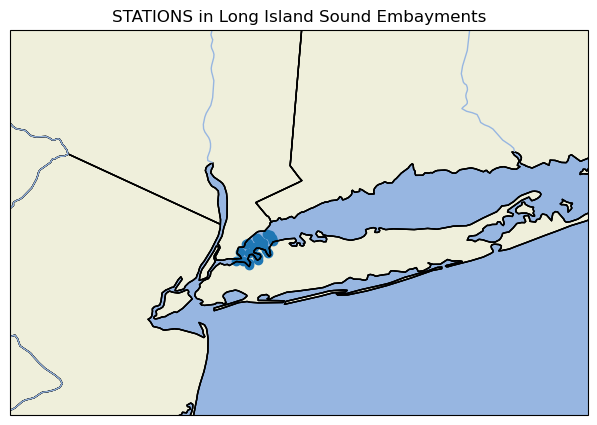

In [373]:
#zoomed out view of the study area
center_lat= 37.5
center_lon= -96
extent = [-72, -75, 40, 42]   

plt.figure(figsize=(10, 5))  
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent(extent)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.STATES)
ax.add_feature(cartopy.feature.STATES)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.BORDERS)
plt.scatter(x=location.LONG_DD, y=location.LAT_DD, transform = ccrs.PlateCarree())  
plt.title("STATIONS in Long Island Sound Embayments")

Text(0.5, 1.0, 'Stations In Long Island Sound Embayments')

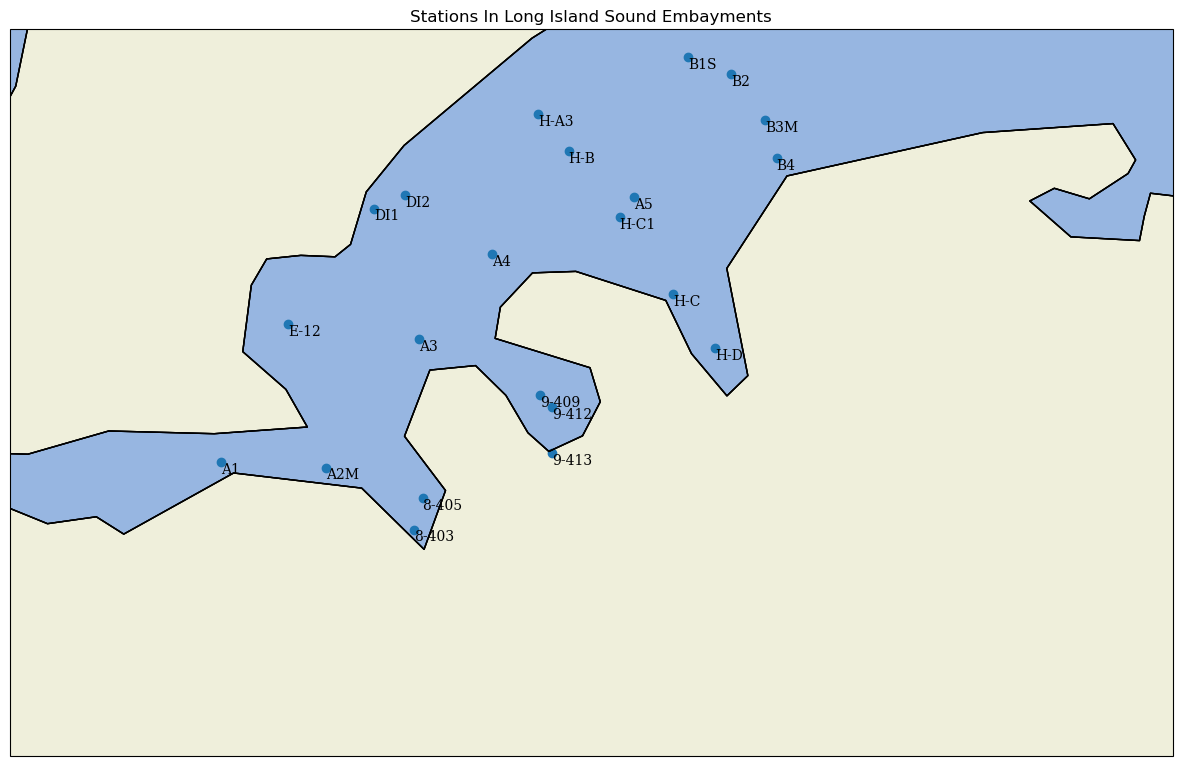

In [375]:
#zoomed in view of the study area and labeled stations

extent = [-73.5, -73.9, 40.7, 40.95]   

stations = location['STATION_ID']
x = location.LONG_DD 
y= location.LAT_DD

plt.figure(figsize=(15, 10))  
ax = plt.axes(projection = ccrs.PlateCarree())

for i in range(len(stations)):
    plt.text(x[i], y[i], stations[i], va='top', family='serif')
    
ax.set_extent(extent)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.STATES)
ax.add_feature(cartopy.feature.STATES)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.BORDERS)
plt.scatter(x, y, transform = ccrs.PlateCarree())  
plt.title("Stations In Long Island Sound Embayments")

## Exploring potential correlations among the data

In [376]:
#are there correlations present between variables in the original dataframe?
df_CORR = df[['DO', 'CHLA_UG_L', 'TEMPERATURE_C', 'PH', 'DEPTH_M', 'PREV_48_H_RAIN', 'SALINITY_PSU']].corr()
df_CORR
#from this it looks like DO is most correlated with temperature, salinity, and depth (top 3)

,DO,CHLA_UG_L,TEMPERATURE_C,PH,DEPTH_M,PREV_48_H_RAIN,SALINITY_PSU
DO,1.000000,-0.182203,-0.775641,0.065150,-0.232763,-0.053690,-0.200874
CHLA_UG_L,-0.182203,1.000000,0.235433,0.130574,0.331619,0.063316,0.209901
TEMPERATURE_C,-0.775641,0.235433,1.000000,-0.029539,-0.069401,0.047639,0.194930
PH,0.065150,0.130574,-0.029539,1.000000,0.059267,0.025425,-0.068511
DEPTH_M,-0.232763,0.331619,-0.069401,0.059267,1.000000,-0.001663,0.214893
PREV_48_H_RAIN,-0.053690,0.063316,0.047639,0.025425,-0.001663,1.000000,-0.164961
SALINITY_PSU,-0.200874,0.209901,0.194930,-0.068511,0.214893,-0.164961,1.000000


In [377]:
#how do the correlations change when we isolate dates where nutrients were also measured?
df_CORR = df_NUTR[['DO', 'CHLA_UG_L', 'TEMPERATURE_C', 'PH', 'DEPTH_M', 'PREV_48_H_RAIN', 'SALINITY_PSU', 'AMMONIA-AMMONIUM_MG_L', 'NITRITE_NITRATE_MG_L', 'PARTICULATE_N_MG_L', 'ORTHOPHOSPHATE_MG_L', 'TOTAL_DISSOLVED_ N_MG_L', 'TOTAL_DISSOLVED_P_MG_L', 'PARTICULATE_P_MG_L', 'DISSOLVED_SILICA_MG_L', 'BIOGENIC_SILICA_MG_L']].corr()
df_CORR
#DO is now most correlated to temperature, orthophosphate, chl-a and dissolved silica (top 4)

,DO,CHLA_UG_L,TEMPERATURE_C,PH,DEPTH_M,PREV_48_H_RAIN,SALINITY_PSU,AMMONIA-AMMONIUM_MG_L,NITRITE_NITRATE_MG_L,PARTICULATE_N_MG_L,ORTHOPHOSPHATE_MG_L,TOTAL_DISSOLVED_ N_MG_L,TOTAL_DISSOLVED_P_MG_L,PARTICULATE_P_MG_L,DISSOLVED_SILICA_MG_L,BIOGENIC_SILICA_MG_L
DO,1.000000,-0.262715,-0.909091,-0.055936,-0.006494,-0.120089,-0.087859,-0.035537,0.119257,0.015477,-0.426148,0.013729,-0.090990,-0.207470,-0.247748,-0.225654
CHLA_UG_L,-0.262715,1.000000,0.358344,0.148022,-0.049807,0.120827,-0.233088,0.011588,-0.225559,0.567509,0.382424,0.102092,-0.015991,0.236844,0.266912,0.077133
TEMPERATURE_C,-0.909091,0.358344,1.000000,0.137421,-0.001819,0.087827,0.102983,0.006626,-0.215977,0.094894,0.401994,-0.095354,0.025231,0.197676,0.298166,0.203182
PH,-0.055936,0.148022,0.137421,1.000000,0.097852,0.202362,-0.278225,-0.563935,0.293231,0.190283,-0.199568,0.601331,-0.724180,-0.709433,0.543741,-0.734203
DEPTH_M,-0.006494,-0.049807,-0.001819,0.097852,1.000000,-0.033027,0.029091,-0.078317,0.066148,-0.034652,-0.044804,0.058235,-0.087056,-0.110159,0.046786,-0.085650
PREV_48_H_RAIN,-0.120089,0.120827,0.087827,0.202362,-0.033027,1.000000,-0.050837,-0.187217,-0.071484,0.126994,-0.097692,0.095538,-0.194383,-0.151244,0.083467,-0.229113
SALINITY_PSU,-0.087859,-0.233088,0.102983,-0.278225,0.029091,-0.050837,1.000000,0.175488,-0.301093,-0.154733,-0.180726,-0.325755,0.132849,0.258497,-0.294760,0.385823
AMMONIA-AMMONIUM_MG_L,-0.035537,0.011588,0.006626,-0.563935,-0.078317,-0.187217,0.175488,1.000000,-0.249681,0.007580,0.436440,-0.471789,0.735108,0.704804,-0.332752,0.779669
NITRITE_NITRATE_MG_L,0.119257,-0.225559,-0.215977,0.293231,0.066148,-0.071484,-0.301093,-0.249681,1.000000,-0.120919,-0.027727,0.651935,-0.163319,-0.335319,0.427065,-0.295375
PARTICULATE_N_MG_L,0.015477,0.567509,0.094894,0.190283,-0.034652,0.126994,-0.154733,0.007580,-0.120919,1.000000,-0.136846,0.161638,0.184416,0.166580,0.126453,-0.010135


### Visualize the correlations between dissolved oxygen and its four most correlated variables

Text(0.5, 1.0, 'DO vs TEMP')

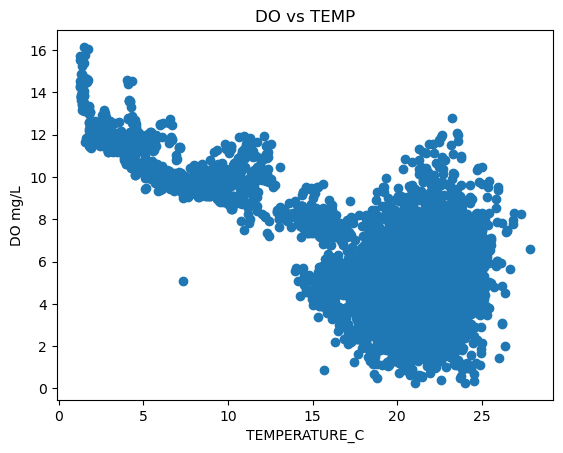

In [379]:
#visualize the correlation between temperature and dissolved oxygen in the original dataframes
ax = plt.scatter(df['TEMPERATURE_C'], df['DO'])
plt.xlabel ('TEMPERATURE_C')
plt.ylabel ('DO mg/L')
plt.title('DO vs TEMP')

Text(0.5, 1.0, 'DO vs Dissolved Silica')

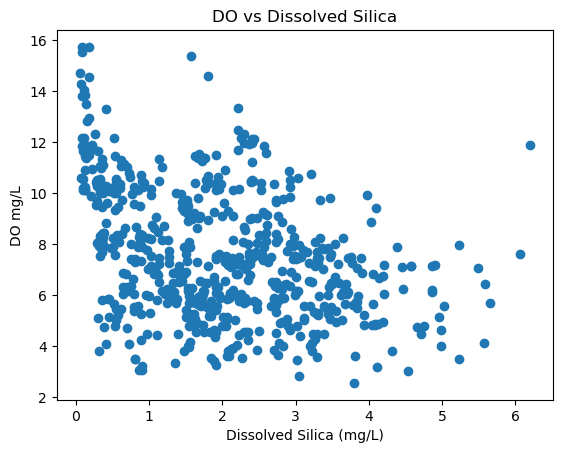

In [380]:
#visualize the correlation between dissolved silica and dissolved oxygen in the original dataframes
ax = plt.scatter(df['DISSOLVED_SILICA_MG_L'], df['DO'])
plt.xlabel ('Dissolved Silica (mg/L)')
plt.ylabel ('DO mg/L')
plt.title('DO vs Dissolved Silica')

Text(0.5, 1.0, 'DO vs CHL-A')

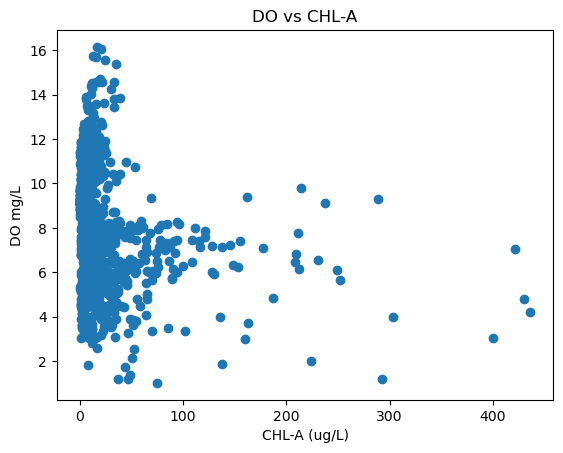

In [381]:
#visualize the correlation between chlorophyll-a and dissolved oxygen in the original dataframes
ax = plt.scatter(df['CHLA_UG_L'], df['DO'])
plt.xlabel ('CHL-A (ug/L)')
plt.ylabel ('DO mg/L')
plt.title('DO vs CHL-A')

Text(0.5, 1.0, 'DO vs OPO4')

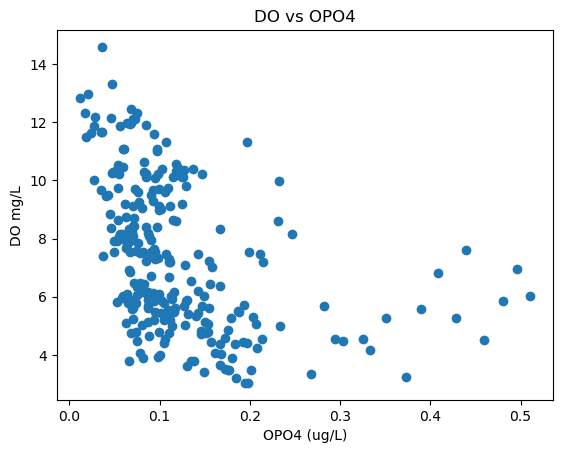

In [382]:
#visualize the correlation between orthophosphate and dissolved oxygen in the original dataframes
ax0 = plt.scatter(df_NUTR['ORTHOPHOSPHATE_MG_L'], df_NUTR['DO'])
plt.xlabel ('OPO4 (ug/L)')
plt.ylabel ('DO mg/L')
plt.title('DO vs OPO4')

## Explore how dissolved oxygen and correlated variables change over time and between stations

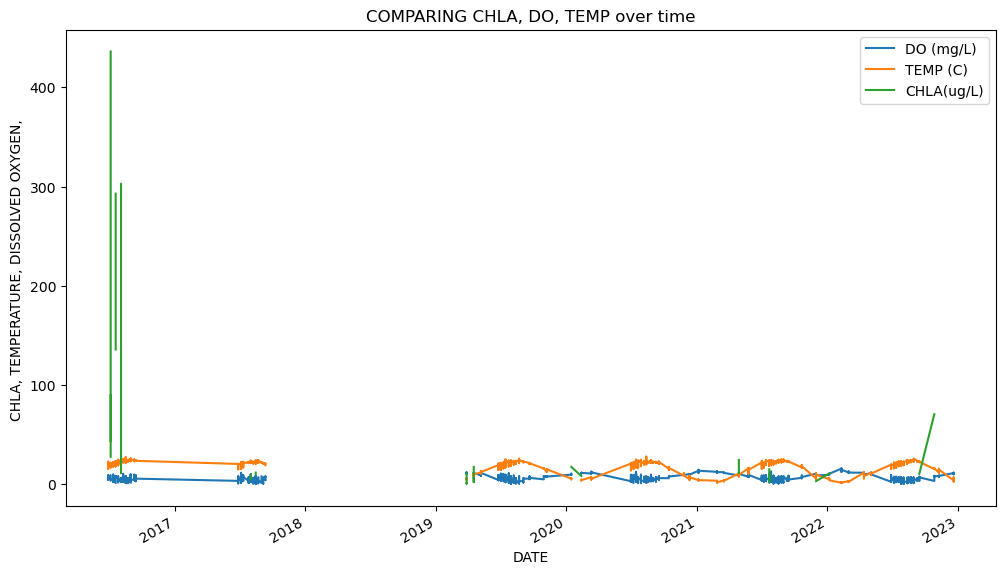

In [384]:
# compare chlorophyll-a, dissolvex oxygen, and temperature over the study period in a timeseries
fig, ax = plt.subplots(figsize = (12, 7))

ax.set_ylabel('CHLA, TEMPERATURE, DISSOLVED OXYGEN, ')
ax.set_title('COMPARING CHLA, DO, TEMP over time')

timeseries_DO = df.DO.plot()
timeseries_T = df.TEMPERATURE_C.plot()
timeseries = df.CHLA_UG_L.plot()
ax.legend(['DO (mg/L)', 'TEMP (C)', 'CHLA(ug/L)']) 

#graph shows very high chlorophyll-a levels in 2017, and from 2019 onward, the DO, TEMP, and CHLA seem to stablelize

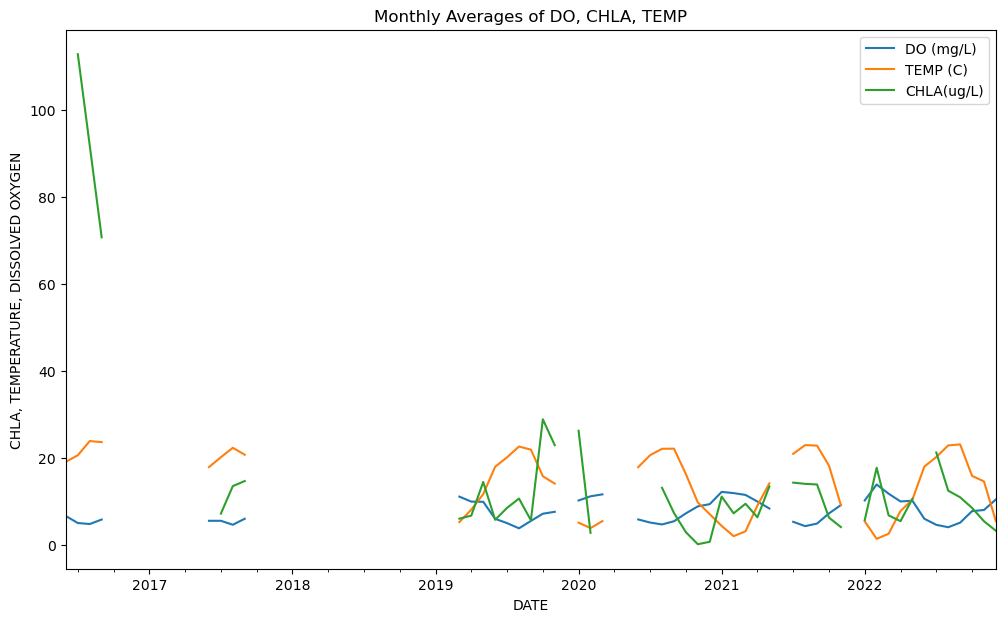

In [385]:
#view monthly averages of chlorophyll-a, temperature, and dissolved oxygen by resampling by month
fig, ax = plt.subplots(figsize = (12, 7))

ax.set_ylabel('CHLA, TEMPERATURE, DISSOLVED OXYGEN')
ax.set_title('Monthly Averages of DO, CHLA, TEMP')

monthly_AVG_DO = df.DO.resample('M').mean().plot()
monthly_AVG_CHLA_UG_L = df.TEMPERATURE_C.resample('M').mean().plot()
monthly_AVG_CHLA_UG_L = df.CHLA_UG_L.resample('M').mean().plot()

ax.legend(['DO (mg/L)', 'TEMP (C)', 'CHLA(ug/L)']) 

#this graph shows that DO is generally inversely related to TEMP and CHLA 

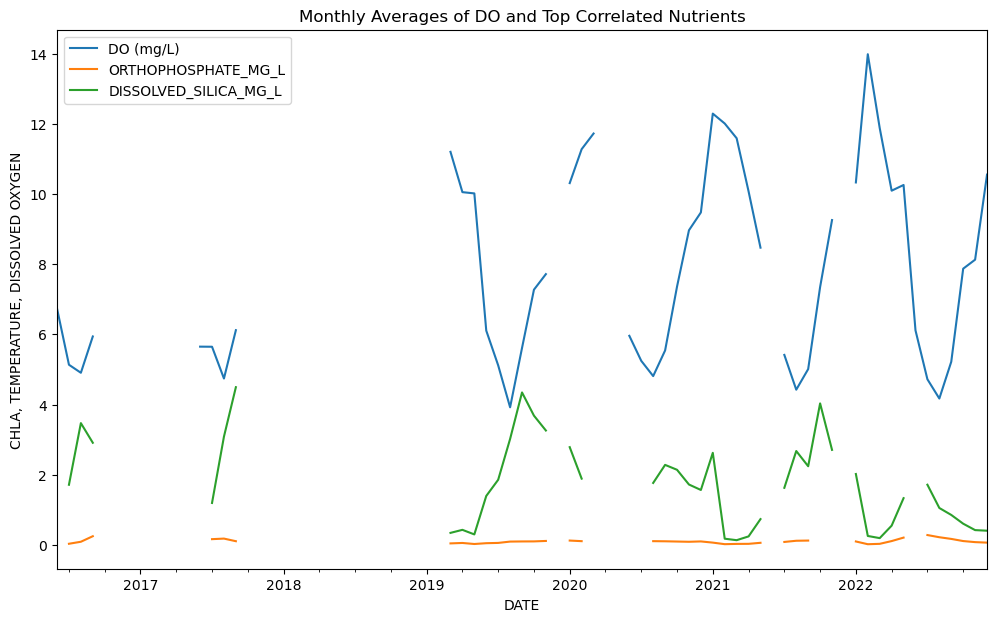

In [386]:
#view monthly averages of orthophosphate and dissolved silica as compared to dissolved oxygen by resampling by month
fig, ax = plt.subplots(figsize = (12, 7))

ax.set_ylabel('CHLA, TEMPERATURE, DISSOLVED OXYGEN')
ax.set_title('Monthly Averages of DO and Top Correlated Nutrients')

monthly_AVG_DO = df.DO.resample('M').mean().plot()
monthly_AVG_CHLA_UG_L = df.ORTHOPHOSPHATE_MG_L.resample('M').mean().plot()
monthly_AVG_CHLA_UG_L = df.DISSOLVED_SILICA_MG_L.resample('M').mean().plot()

ax.legend(['DO (mg/L)', 'ORTHOPHOSPHATE_MG_L', 'DISSOLVED_SILICA_MG_L']) 

#this graph shows that DO is generally inversely related to TEMP and CHLA 

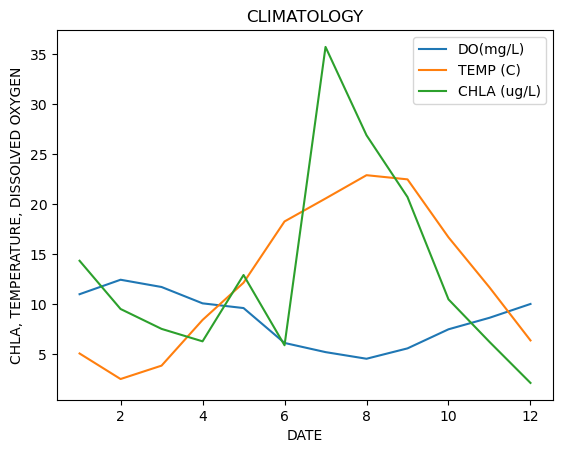

In [387]:
#get climatology by using groupby index method
#results show the lowest oxygen is in August, when temperature and chl-a is the highest
monthly_climatology = df.groupby(df.index.month).mean(numeric_only=True)

fig, ax = plt.subplots()

ax.set_ylabel('CHLA, TEMPERATURE, DISSOLVED OXYGEN')
ax.set_title('CLIMATOLOGY')

monthly_climatology.DO.plot()
monthly_climatology.TEMPERATURE_C.plot()
monthly_climatology.CHLA_UG_L.plot()

ax.legend(['DO(mg/L)', 'TEMP (C)', 'CHLA (ug/L)']) 

### Analysis By Station

In [393]:
#will use the original stations only so results can be viewed
#if include the dups, the results will be too cluttered
#remove duplicates
#make new dataframe
df_sim = df[df["STATION_ID"].str.contains("DUP") == False]

In [389]:
df_simp = df_sim[df_sim["STATION_ID"].str.contains("dup") == False]

In [390]:
df_simple = df_simp[df_simp["STATION_ID"].str.contains("Dup") == False]

In [391]:
df_simple

,STATION_ID,RECORD_ID,DATE_STATION_LINK,YEAR,MONTH,TIME_24H,DEPTH_M,CLASS,DO,TEMPERATURE_C,...,DISSOLVED_SILICA_MG_L,BIOGENIC_SILICA_MG_L,INVESTIGATION,STATION_ID_B,SEA_STATE,WEATHER,PREV_24_H_RAIN,PREV_48_H_RAIN,LAT_DD,LONG_DD
DATE,,,,,,,,,,,,,,,,,,,,,
2016-06-28,9-413,9-413_6/28/2016_08:00_1.0,6/28/2016_9-413,2016.0,6,8:00,1.0,Surface,7.85,21.500,...,NaN,NaN,17584,9-413-S,ripples,Overcast,0.54,0.54,40.80436,-73.71353
2016-06-28,9-413,9-413_6/28/2016_07:58_2.6,6/28/2016_9-413,2016.0,6,7:58,2.6,Bottom,7.12,20.900,...,NaN,NaN,17584,9-413-B,ripples,Overcast,0.54,0.54,40.80436,-73.71353
2016-06-28,9-412,9-412_6/28/2016_08:12_1.0,6/28/2016_9-412,2016.0,6,8:12,1.0,Surface,8.17,21.290,...,NaN,NaN,17584,9-412-S,ripples,Overcast,0.54,0.54,40.82009,-73.71357
2016-06-28,9-412,9-412_6/28/2016_08:12_2.3,6/28/2016_9-412,2016.0,6,8:12,2.3,Middle,8.13,21.030,...,NaN,NaN,17584,9-412-M,ripples,Overcast,0.54,0.54,40.82009,-73.71357
2016-06-28,9-412,9-412_6/28/2016_08:10_4.7,6/28/2016_9-412,2016.0,6,8:10,4.7,Bottom,7.54,20.260,...,NaN,NaN,17584,9-412-B,ripples,Overcast,0.54,0.54,40.82009,-73.71357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,A5,A5_12/20/2022_12:53_5.2,12/20/2022_A5,2022.0,December,12:53,5.2,Middle,10.30,6.176,...,NaN,NaN,NaN,NaN,A5_M,0,1 ft,NaN,40.89229,-73.68531
2022-12-20,A5,A5_12/20/2022_12:54_0.5,12/20/2022_A5,2022.0,December,12:54,0.5,Surface,10.34,6.186,...,0.323,2.490,14.13,116.60,A5_S,0,1 ft,NaN,40.89229,-73.68531
2022-12-20,A4,A4_12/20/2022_13:31_29.1,12/20/2022_A4,2022.0,December,13:31,29.1,Bottom,10.22,6.438,...,NaN,NaN,NaN,NaN,A4_B,0,1 ft,NaN,40.87259,-73.73428


In [394]:
#lets see which stations have the lowest DO and highest DO overall?
#first groupy by STATION_ID
grouped = df_simple.groupby('STATION_ID')

In [395]:
highest_DO = grouped.DO.mean().nlargest(10)
highest_DO

STATION_ID
DI-2     11.006667
DI-1     10.975000
B4        7.157482
9-409     6.971763
9-412     6.835401
E-12      6.761479
8-405     6.742248
H-C1      6.638723
A5        6.626596
H-C       6.618035
Name: DO, dtype: float64

In [396]:
lowest_DO= grouped.DO.mean().nsmallest(10)
lowest_DO

STATION_ID
HB       3.436667
HD       3.673333
9-413    5.131220
A2M      5.507732
A1       5.648797
A4       5.692316
A3       5.721767
DI2      6.096910
DI1      6.157193
H-D      6.220381
Name: DO, dtype: float64

Text(0, 0.5, 'Dissolved_Oxygen_mg/L')

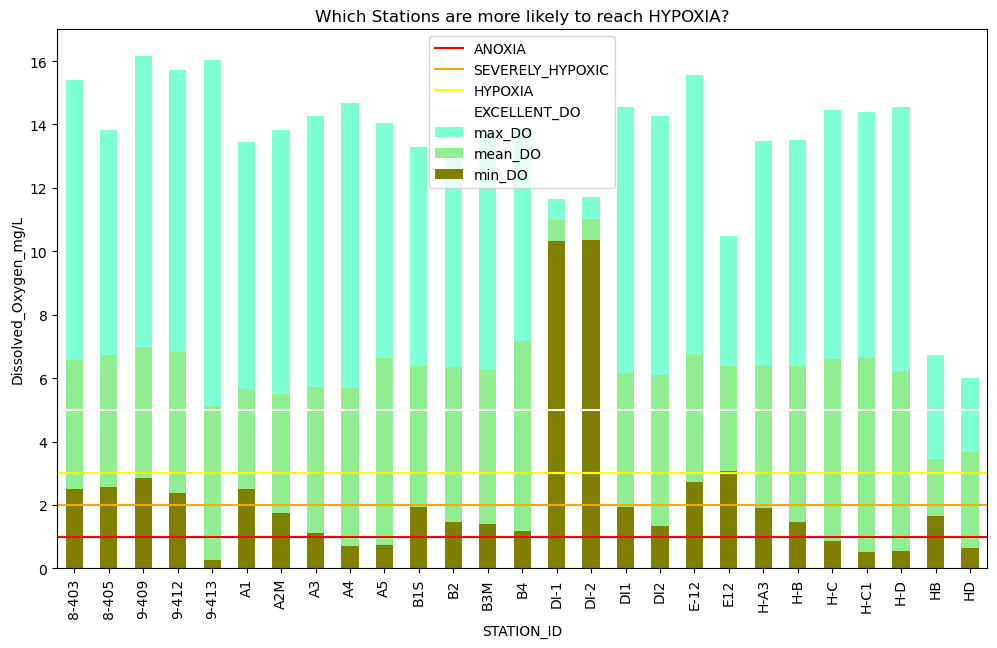

In [400]:
#Which stations are most likely to become hypoxic?
#Show the stations DO statistics compared to Dissolved Oxygen Benchmarks
#Can see that station DI-1 and DI2 have the highest DO mean and station HB has the lowest DO mean
fig, ax = plt.subplots(figsize = (12, 7))

max_DO = df_simple.groupby('STATION_ID').DO.max().plot(color = 'aquamarine', kind = 'bar')
mean_DO = df_simple.groupby('STATION_ID').DO.mean().plot(color = 'lightgreen', kind = 'bar')
min_DO = df_simple.groupby('STATION_ID').DO.min().plot(color = 'olive', kind = 'bar')
ANOXIA = plt.axhline(y = 1, color = 'RED', linestyle = '-') 
SEVERELY_HYPOXIC = plt.axhline(y = 2, color = 'ORANGE', linestyle = '-') 
HYPOXIA = plt.axhline(y = 3, color = 'YELLOW', linestyle = '-') 
EXCELLENT_DO = plt.axhline(y = 5, color = 'snow', linestyle = '-') 
plt.axis(ymin= 0, ymax = 17)

ax.legend(['ANOXIA', 'SEVERELY_HYPOXIC', 'HYPOXIA', 'EXCELLENT_DO','max_DO', 'mean_DO', 'min_DO', ])
ax.set_title('Which Stations are more likely to reach HYPOXIA?')
ax.set_ylabel('Dissolved_Oxygen_mg/L')

## Build a Model to Predict DO

In [453]:
#Will use statsmodel to predict DO using df_NUTR
df_NUTR = df_NUTR.reset_index()

In [454]:
#split data into two parts, to train the model and to test the model
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_NUTR, test_size=0.2)

In [455]:
test

,index,DATE,STATION_ID,RECORD_ID,DATE_STATION_LINK,YEAR,MONTH,TIME_24H,DEPTH_M,CLASS,...,DISSOLVED_SILICA_MG_L,BIOGENIC_SILICA_MG_L,INVESTIGATION,STATION_ID_B,SEA_STATE,WEATHER,PREV_24_H_RAIN,PREV_48_H_RAIN,LAT_DD,LONG_DD
248,248,2022-11-09,B1S,B1S_11/9/2022_9:17_0.5,11/9/2022_B1S,2022.0,November,9:17,0.5,Surface,...,0.312,3.0000,15.7,116.15,B1S_S,0,3 ft,NaN,40.94037,-73.66656
237,237,2022-10-27,B3M,B3M_10/27/2022_9:00_0.6,10/27/2022_B3M,2022.0,October,9:00,0.6,Surface,...,0.375,3.2500,16.51,105.70,B3M_S,5,3 ft,NaN,40.91890,-73.64013
251,251,2022-11-09,A5,A5_11/9/2022_9:53_0.6,11/9/2022_A5,2022.0,November,9:53,0.6,Surface,...,0.345,3.0900,11.17,116.00,A5_S,0,3 ft,NaN,40.89229,-73.68531
36,36,2020-09-16,8-403,8-403_9/16/2020_6:34_0.6,9/16/2020_8-403,2020.0,September,6:34,0.6,Surface,...,2.730,0.5900,18033.0,8-403_S,ripples,"Hazy, sunny",0.0,0.00,40.77791,-73.76083
135,135,2021-08-17,A5,A5_8/17/2021_9:07_0.5,08/17/2021_A5,2021.0,August,9:07,0.5,Surface,...,2.960,0.0800,18219.0,A5_S,< 1 ft,"Cloudy, calm waters",0.0,0.00,40.89229,-73.68531
128,128,2021-08-17,8-403,8-403_8/17/2021_6:32_0.5,08/17/2021_8-403,2021.0,August,6:32,0.5,Surface,...,3.690,0.4200,18219.0,8-403_S,Ripples,"Cloudy, calm waters",0.0,0.00,40.77791,-73.76083
213,213,2022-08-30,DI2,DI2_8/30/2022_8:35_0.5,8/30/2022_DI2,2022.0,August,8:35,0.5,Surface,...,0.836,4.2300,30-Aug,18480,75,NaN,"Overcast, then partly cloudy; 73°F air temp, 8...",0.00,40.89306,-73.76405
54,54,2020-10-14,B3M,B3M_10/14/2020_8:58_0.6,10/14/2020_B3M,2020.0,October,8:58,0.6,Surface,...,1.950,0.3000,18052.0,B3M_S,2 ft,Sunny,0.13,0.13,40.91890,-73.64013
78,78,2020-12-11,E-12 Dup,E-12 Dup_12/11/2020_8:09_0.5,12/11/2020_E-12 Dup,2020.0,December,8:09,0.5,Surface,...,1.520,0.1400,18066.0,E-12 Dup_S,ripples,"cold, clear, mostly sunny",0.0,0.02,NaN,NaN
185,185,2022-07-19,A2M,A2M_7/19/2022_8:51_0.5,7/19/2022_A2M,2022.0,July,8:51,0.5,Surface,...,1.630,2.6200,19-Jul,18404,0,NaN,"Partly cloudy, windy, 79°F air temp, 8-15 mph ...",0.10,40.79926,-73.79131


In [469]:
#make X and Y Matrix
#will use the top four correlated variables to build the model
Y,X = dmatrices ('DO~ CHLA_UG_L + TEMPERATURE_C + ORTHOPHOSPHATE_MG_L + DISSOLVED_SILICA_MG_L ', data=train, return_type='dataframe')

In [470]:
#use statmodel api, inputs are design matrices
mod = sm.OLS(Y, X)

#update matrix so it has constant added to it
X= sm.add_constant(X) 

In [475]:
#fit the model
res = mod.fit()
#check the model statistics
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DO   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     294.0
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           1.08e-83
Time:                        22:58:22   Log-Likelihood:                -293.35
No. Observations:                 210   AIC:                             596.7
Df Residuals:                     205   BIC:                             613.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.6851      0.181     70.160      0.000      12.329      13.042
CHLA_UG_L                 0.0315      0.009      3.484      0.001       0.014       0.049
TEMPERATURE_C            -0.3120      0.011    -29.374      0.000      -0.333      -0.291
ORTHOPHOSPHATE_MG_L      -3.7197      0.952     -3.908      0.000      -5.596      -1.843
DISSOLVED_SILICA_MG_L     0.0418      0.077      0.539      0.590      -0.111       0.195
==============================================================================
Omnibus:                        3.112   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                3.140
Skew:                           0.123   Prob(JB):                        0.208
Kurtosis:                       3.546   Cond. No.                         295.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [476]:
#test the model with the test data
Y_test,X_test = dmatrices ('DO~ CHLA_UG_L + TEMPERATURE_C + ORTHOPHOSPHATE_MG_L + DISSOLVED_SILICA_MG_L ', data=test, return_type='dataframe')
y_pred = res.predict(exog = X_test)

In [477]:
y_pred

248     7.796523
237     7.568668
251     7.806323
36      6.055781
135     5.080276
128     5.109288
213     4.342851
54      7.248743
78     10.485162
185     5.584992
72     10.393050
261    10.705378
227     5.404986
262    11.104526
39      5.569736
96      9.330568
85     11.336481
43      6.241169
218     4.249140
40      5.629398
160    11.542965
146     5.139195
193     5.443224
197     5.307914
87     11.546979
25      5.857111
52      7.381827
171     9.774220
113     6.900790
33      5.796238
22      5.895828
263    10.646626
204     5.362979
109     8.066953
79     12.404418
181     8.630956
99      7.926651
195     5.327186
118     5.701075
114     6.257814
53      7.364212
222     5.491295
209     5.362628
112     6.384147
147     4.869572
219     4.758664
77     10.246850
252     7.828549
107     7.945622
229     5.439128
242     7.856476
150     5.336616
18      5.827159
dtype: float64

In [478]:
#add predicted dissolved oxygen values as a new column to test dataframe
test['DO_Predicted'] = y_pred

In [479]:
#compare the true values to the predicted values
test[['DO', 'DO_Predicted']]

,DO,DO_Predicted
248,7.97,7.796523
237,8.43,7.568668
251,8.08,7.806323
36,5.62,6.055781
135,7.94,5.080276
128,6.43,5.109288
213,5.46,4.342851
54,7.58,7.248743
78,9.74,10.485162
185,4.99,5.584992


Text(0.5, 1.0, 'CLIMATOLOGY')

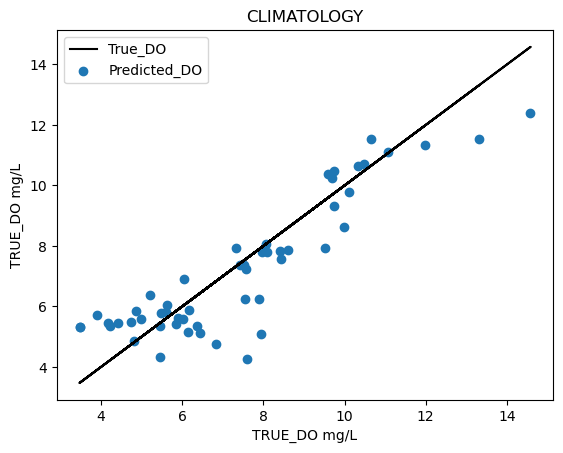

In [480]:
#compare the true DO values to the Predicted DO values visually
fig, ax = plt.subplots()
ax.plot(test['DO'],test['DO'], color = 'BLACK')
ax.scatter(test['DO'], test['DO_Predicted'])
ax.legend(['True_DO', 'Predicted_DO'])
ax.set_xlabel('TRUE_DO mg/L')
ax.set_ylabel('TRUE_DO mg/L')
ax.set_title('CLIMATOLOGY')

In [481]:
#Model looks pretty good!